In [1]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd
import seaborn as sns


In [2]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100
    print("Start")
    print(matched_count)
    print(unmatched_count)
    print(spikes_with_duplicates)
    print(len(list1))
    print(len(list2))
    print(rate_of_agreement)
    print("\n")

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [3]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [ ]:
# Fetch the true sources
file_path_mat = '../data/matlabSpikes50.mat'
# Create a dictionary from the matlab data file.
data_dict_mat = scipy.io.loadmat(file_path_mat)


# Extract the EMG spike data into a numpy array
MUPulsesMat = np.array(data_dict_mat['spikeMat'])


spikeList = []
for idx in range(len(MUPulsesMat)):
    sourceList = []
    for index, value in enumerate(MUPulsesMat[idx]):
        if value == 1:
            sourceList.append(index)
    spikeList.append(sourceList)


In [ ]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB['SpikeTrain']
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates

    loopidx = 1

print(roa_matrix)
print(dup_matrix)

In [4]:
def create_binary_list(indices, total_length):
    """
    Create a binary list where indices are marked as 1s.
    """
    binary_list = [0] * (total_length+1)
    for index in indices:
        binary_list[index] = 1
    return binary_list

def calculate_rate_of_agreement(list1, list2):
    """
    Calculate the rate of agreement between two lists of spike indices.
    """
    total_indices = len(list1)+len(list2)
    max_length = max(list1[-1], list2[-1])
    max_agreement = 0
    best_shift = 0
       # Create binary lists for list1 and list2
    binary_list1 = create_binary_list(list1, max_length)
    binary_list2 = create_binary_list(list2, max_length)


    # Iterate through possible shifts
    for shift in range(-10, 11):
        agreement_count = 0

        # Shift binary_list1 by shift amount
        shifted_binary_list1 = [0] * max_length
        if shift < 0:
            shifted_binary_list1[-shift:] = binary_list1[:shift]
        elif shift > 0:
            shifted_binary_list1[:-shift] = binary_list1[shift:]


 
        # Perform element-wise multiplication and sum
        for i in range(max_length):
            agreement_count += shifted_binary_list1[i] * binary_list2[i]

        # Calculate rate of agreement for current shift
        rate_of_agreement = (agreement_count * 2 / total_indices) * 100

        # Update max agreement and best shift if current shift has higher rate of agreement
        if rate_of_agreement > max_agreement:
            max_agreement = rate_of_agreement
            best_shift = shift

    return best_shift, max_agreement

# Example usage
list1 = [1, 3, 5, 7, 9]
list2 = [2, 4, 6, 8, 10]
shift, rate_of_agreement = calculate_rate_of_agreement(list1, list2)
print("Best shift:", shift)
print("Rate of agreement:", rate_of_agreement)

Best shift: -1
Rate of agreement: 80.0


In [5]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()
#MUPulsesB = spikeList

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
shift_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        print(idxA, idxB)
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))


        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)

        
        roa_matrix.iloc[idxA, idxB] = rate_of_agreement 
        shift_matrix.iloc[idxA, idxB] = shift 


    loopidx = 1

print(roa_matrix)


(56, 34)
0 0
0 1
0 2


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.33422281521014' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3531799729364005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4464168310322156' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 3
0 4
0 5


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2219959266802443' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0832769126607988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0767160161507403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 6
0 7
0 8


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9327115256495668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2186865267433988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1065006915629323' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/

0 9
0 10
0 11


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1004126547455295' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2379642365887207' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.367053998632946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 12
0 13
0 14


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.196013289036545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2422360248447204' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3783597518952446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 15
0 16
0 17


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9728978457261988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9628610729023385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5978695073235687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 18
0 19
0 20


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1042097998619738' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1984021304926764' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3486176668914363' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 21
0 22
0 23


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2113055181695829' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9277667329357191' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.21049092131809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 24
0 25
0 26


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1673151750972763' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0854816824966078' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9277667329357191' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 27
0 28
0 29


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9277667329357191' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2121212121212122' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6271186440677967' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 30
0 31
0 32


/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9339559706470981' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_144126/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.957592339261286' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 33
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
5 31
5 32
5 33
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
6 31
6 32
6 33
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8

In [ ]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(shift_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Best Shifts')

# Step 5: Show or Save the Plot
plt.show()

In [ ]:
max_index = np.unravel_index(np.argmax(roa_matrix), roa_matrix.shape)

print("Indices of the maximum value:", max_index)

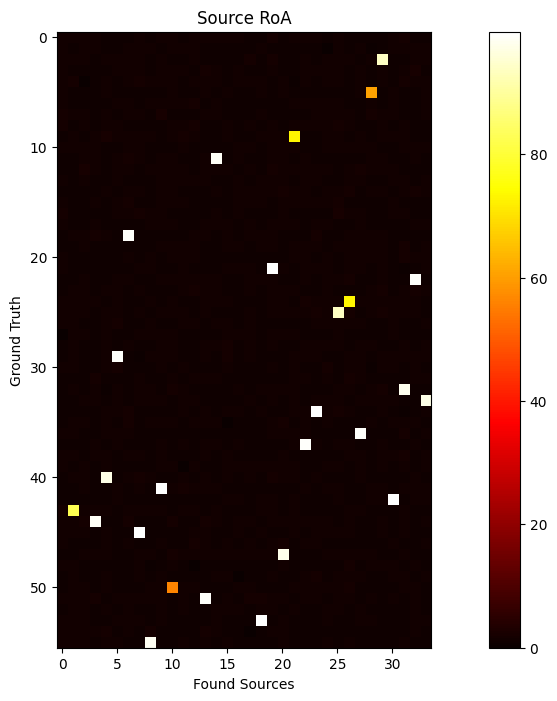

In [6]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(roa_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Source RoA')

# Step 5: Show or Save the Plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
sns.lineplot(spikeCountTrue, label='Ground Truth', ax=ax)

# Plot the second line
sns.lineplot(spikeCountCalc, label='Measured', ax=ax)

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Line Plot Example')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
print(shift_matrix[0][18])

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[50][0]
list2 = MUPulsesB[10]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()
print(roa_matrix[7][6])
print(roa_matrix[5][1])

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[5]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
for list in MUPulsesB:
    plt.figure(figsize=(15, 2))
    time_interval_indices = np.divide(list["SpikeTrain"], 4096)
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlim([0,30])
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [ ]:
print(np.divide(list2,2))

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[30][0]
list2 = MUPulsesB[12]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
sns.heatmap(roa_matrix, cmap='coolwarm')

In [ ]:
sns.heatmap(dup_matrix, cmap='coolwarm')